В этом домашнем задании вы будете решать задачу классификации оттоковых клиентов телекома: для каждого клиента необходимо определить, перестанет он пользоваться услугами оператора в ближайшее время или нет.

In [296]:
# Clear all variables and functions
# %reset -f

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [225]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_first_step_in_nlp/main/datasets/telecom_churn.csv")
df.head()

State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   Total night minutes  Total night calls  Total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   Customer service calls  Churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False

Сделаем первичную обработку данных:

1) Выбросите колонку State

**Вопрос:** сколько столбцов осталось в матрице df?

In [226]:
df.shape

(3333, 20)

In [227]:
df = df.drop(columns='State')
df.shape

(3333, 19)

Сделаем простую кодировку признаков: 

2) Колонку International plan закодируем следующим образом: "Yes" замените на 1, а "No" на 0.

In [228]:
df['International plan'] = df['International plan'].map({'Yes' : 1, 'No' : 0})

Аналогичным образом закодируйте столбец Voice mail plan.

In [229]:
df['Voice mail plan'].unique()

array(['Yes', 'No'], dtype=object)

In [230]:
df['Voice mail plan'] = df['Voice mail plan'].map({'Yes' : 1, 'No' : 0})

In [231]:
df['Voice mail plan'].unique()

array([1, 0], dtype=int64)

3) Переведем целевую переменную (Churn) в числа: True в 1, а False в 0.

In [232]:
df['Churn'] = df['Churn'].astype(int)
df.head(20)

Account length  Area code  International plan  Voice mail plan  \
0              128        415                   0                1   
1              107        415                   0                1   
2              137        415                   0                0   
3               84        408                   1                0   
4               75        415                   1                0   
5              118        510                   1                0   
6              121        510                   0                1   
7              147        415                   1                0   
8              117        408                   0                0   
9              141        415                   1                1   
10              65        415                   0                0   
11              74        415                   0                0   
12             168        408                   0                0   
13              95        510                   0                0   
14              62        415                   0                0   
15             161        415                   0                0   
16              85        408                   0                1   
17              93        510                   0                0   
18              76        510                   0                1   
19              73        415                   0                0   

    Number vmail messages  Total day minutes  Total day calls  \
0                      25              265.1              110   
1                      26              161.6              123   
2                       0              243.4              114   
3                       0              299.4               71   
4                       0              166.7              113   
5                       0              223.4               98   
6                      24              218.2               88   
7                       0              157.0               79   
8                       0              184.5               97   
9                      37              258.6               84   
10                      0              129.1              137   
11                      0              187.7              127   
12                      0              128.8               96   
13                      0              156.6               88   
14                      0              120.7               70   
15                      0              332.9               67   
16                     27              196.4              139   
17                      0              190.7              114   
18                     33              189.7               66   
19                      0              224.4               90   

    Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0              45.07              197.4               99             16.78   
1              27.47              195.5              103             16.62   
2              41.38              121.2              110             10.30   
3              50.90               61.9               88              5.26   
4              28.34              148.3              122             12.61   
5              37.98              220.6              101             18.75   
6              37.09              348.5              108             29.62   
7              26.69              103.1               94              8.76   
8              31.37              351.6               80             29.89   
9              43.96              222.0              111             18.87   
10             21.95              228.5               83             19.42   
11             31.91              163.4              148             13.89   
12             21.90              104.9               71              8.92   
13             26.62              247.6               75             21.05 

Выведите на экран первые строки измененной таблицы, чтобы проверить, что все преобразования сработали.

In [233]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

In [234]:
df.head(20)

Account length  Area code  International plan  Voice mail plan  \
0              128        415                   0                1   
1              107        415                   0                1   
2              137        415                   0                0   
3               84        408                   1                0   
4               75        415                   1                0   
5              118        510                   1                0   
6              121        510                   0                1   
7              147        415                   1                0   
8              117        408                   0                0   
9              141        415                   1                1   
10              65        415                   0                0   
11              74        415                   0                0   
12             168        408                   0                0   
13              95        510                   0                0   
14              62        415                   0                0   
15             161        415                   0                0   
16              85        408                   0                1   
17              93        510                   0                0   
18              76        510                   0                1   
19              73        415                   0                0   

    Number vmail messages  Total day minutes  Total day calls  \
0                      25              265.1              110   
1                      26              161.6              123   
2                       0              243.4              114   
3                       0              299.4               71   
4                       0              166.7              113   
5                       0              223.4               98   
6                      24              218.2               88   
7                       0              157.0               79   
8                       0              184.5               97   
9                      37              258.6               84   
10                      0              129.1              137   
11                      0              187.7              127   
12                      0              128.8               96   
13                      0              156.6               88   
14                      0              120.7               70   
15                      0              332.9               67   
16                     27              196.4              139   
17                      0              190.7              114   
18                     33              189.7               66   
19                      0              224.4               90   

    Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0              45.07              197.4               99             16.78   
1              27.47              195.5              103             16.62   
2              41.38              121.2              110             10.30   
3              50.90               61.9               88              5.26   
4              28.34              148.3              122             12.61   
5              37.98              220.6              101             18.75   
6              37.09              348.5              108             29.62   
7              26.69              103.1               94              8.76   
8              31.37              351.6               80             29.89   
9              43.96              222.0              111             18.87   
10             21.95              228.5               83             19.42   
11             31.91              163.4              148             13.89   
12             21.90              104.9               71              8.92   
13             26.62              247.6               75             21.05 

Создайте матрицу объект-признак X и вектор с целевой переменной (Churn) y.

In [235]:
X = df.drop(columns='Churn')
y = df[['Churn']]

Проверьте баланс классов целевой переменной. Является ли выборка сбалансированной?

**Вопрос:** сколько объектов относятся к классу 1?

In [236]:
df['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [237]:
y.value_counts()

Churn
0        2850
1         483
dtype: int64

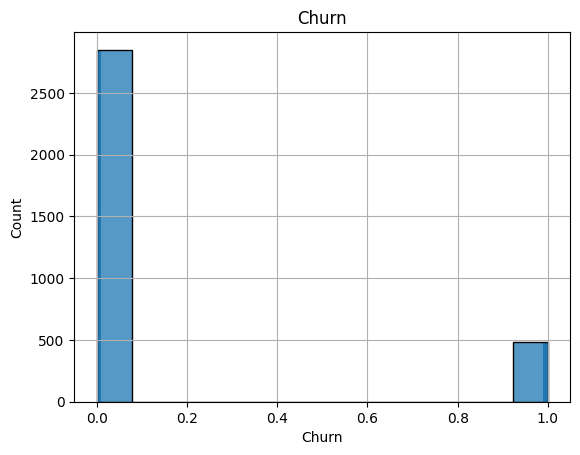

In [238]:

y.hist(bins=100);
sns.histplot(y, x='Churn');

### Разделим данные на тренировочную и тестовую части, размер тестовой части - 30%.

It is recommended to apply feature scaling, such as using Standard Scaler, after splitting the data into training and testing sets. The reason for this is to avoid data leakage from the testing set to the training set.

If you apply scaling before splitting the data, then the scaling parameters (e.g., mean and standard deviation) will be calculated based on the whole dataset, including both the training and testing sets. This means that information from the testing set will influence the training set, which can lead to overly optimistic performance estimates during model evaluation.

To avoid this issue, you should first split the data into training and testing sets, and then fit the scaler on the training set only. The scaling parameters should be calculated based on the training set alone, and then applied to both the training and testing sets. This ensures that the testing set remains unseen during preprocessing, which is crucial for unbiased performance evaluation of the model.


In [239]:
train_data, test_data = train_test_split(df, test_size=0.30, random_state=5)

print('Размер обучающей выборки:', train_data.shape[0])
print('Размер тестовой выборки:', test_data.shape[0])

Размер обучающей выборки: 2333
Размер тестовой выборки: 1000


### Теперь применим, если требуется, кодирование признаков.
В данной задаче не требуется, поэтому продолжим выделение X_train, y_train, X_test, y_test и масштабирование признаков.

In [240]:
X_train = train_data.drop(['Churn'], axis=1)
y_train = train_data['Churn']

X_test = test_data.drop(['Churn'], axis=1)
y_test = test_data['Churn']

print('Обучающая выборка (признаки):', X_train.shape[0])
print('Обучающая выборка (таргет)', y_train.shape[0])
print()
print('Тестовая выборка (признаки):', X_test.shape[0])
print('Тестовая выборка (таргет)', y_test.shape[0])

Обучающая выборка (признаки): 2333
Обучающая выборка (таргет) 2333

Тестовая выборка (признаки): 1000
Тестовая выборка (таргет) 1000


#### Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируйте признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

Для восстановления DataFrame-ов из преобразованных объектов используйте код с занятия.

In [241]:
# from sklearn.preprocessing import StandardScaler   # x -> (x - mean) / std

ss = StandardScaler()
ss.fit(X_train) # вычисляем mean и std

X_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns) # масштабирование
X_test = pd.DataFrame(ss.transform(X_test), columns=X_train.columns)

In [242]:
X_train.head()

Account length  Area code  International plan  Voice mail plan  \
0        1.148368   1.697608           -0.333095         1.667693   
1       -0.224822  -0.531212           -0.333095        -0.599631   
2       -1.573044  -0.531212           -0.333095        -0.599631   
3        1.323138   1.697608           -0.333095         1.667693   
4        0.449290  -0.531212           -0.333095         1.667693   

   Number vmail messages  Total day minutes  Total day calls  \
0               1.890766           1.340584         0.326065   
1              -0.574277           0.345897        -0.818983   
2              -0.574277           0.298444        -0.321136   
3               1.816068           0.260117        -0.918552   
4               2.040163           0.712745        -0.420705   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0          1.341063           0.621197         0.510146          0.621491   
1          0.345838           1.316220         0.258343          1.316047   
2          0.298600          -0.314715        -0.245262         -0.314650   
3          0.259950          -0.737258         1.718797         -0.737423   
4          0.713009           0.358589         1.718797          0.359000   

   Total night minutes  Total night calls  Total night charge  \
0             0.254232          -0.685950            0.252840   
1            -0.832931           0.258378           -0.833200   
2             0.451717          -0.528562            0.452316   
3             0.086670          -1.367966            0.088825   
4             0.974353          -0.371174            0.975389   

   Total intl minutes  Total intl calls  Total intl charge  \
0            0.055529          0.610547           0.057504   
1            0.197929         -0.199235           0.202539   
2            0.197929          0.205656           0.202539   
3           -0.442872         -1.413908          -0.443526   
4           -0.798872          0.205656          -0.799521   

   Customer service calls  
0                1.073971  
1               -0.425475  
2                1.073971  
3                0.324248  
4                0.324248

In [243]:
X_test.head()

Account length  Area code  International plan  Voice mail plan  \
0       -0.224822   1.697608           -0.333095        -0.599631   
1        0.074784  -0.531212           -0.333095        -0.599631   
2       -0.299723  -0.695441           -0.333095        -0.599631   
3        0.574125  -0.531212           -0.333095        -0.599631   
4       -0.699196   1.697608           -0.333095        -0.599631   

   Number vmail messages  Total day minutes  Total day calls  \
0              -0.574277          -0.698068        -0.121997   
1              -0.574277          -0.699893        -1.117691   
2              -0.574277           0.256466        -0.868767   
3              -0.574277           0.006426        -1.416399   
4              -0.574277           1.398988        -1.018121   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0         -0.697699          -0.547706         2.172042         -0.546943   
1         -0.699847          -0.000770         0.963390         -0.001054   
2          0.256729          -0.770824        -0.597785         -0.769944   
3          0.006581           0.611324         1.718797          0.612199   
4          1.399038          -2.220106        -1.051030         -2.219453   

   Total night minutes  Total night calls  Total night charge  \
0             0.018847           1.832259            0.017900   
1             0.058743           0.100990            0.057796   
2            -0.617493           1.989647           -0.615992   
3            -0.423998          -0.476100           -0.425381   
4            -0.942644          -2.102443           -0.944021   

   Total intl minutes  Total intl calls  Total intl charge  \
0           -0.300472          1.015438          -0.298491   
1            0.375929          0.205656           0.373944   
2           -1.475273         -0.604126          -1.471957   
3            0.625129         -1.009017           0.624460   
4            0.126729          1.420329           0.123429   

   Customer service calls  
0                0.324248  
1                0.324248  
2               -1.175199  
3               -1.175199  
4               -1.175199

## Модели
Обучите на тренировочных данных с параметрами по умолчанию:

1) **Логистическую регрессию**

2) **Метод ближайших соседей**

### 1 - Logistic Regression

In [244]:
model = LogisticRegression() # объявляем модель

model.fit(X_train, y_train) # обучаем модель

LogisticRegression()

С помощью обученных моделей сделайте предсказание на тестовых данных. Вычислите значение метрики roc-auc на тесте. 

Не забудьте, что для корректного вычисления roc-auc необходимо предсказывать не сами классы, а их вероятности.

**Вопрос:** чему равен ROC-AUC логистической регрессии, округленный до десятых?

In [245]:
pred_test = model.predict(X_test) # предсказание классов

In [246]:
pred_test[:5]

array([0, 0, 0, 0, 0])

In [247]:
accuracy_score(y_test, pred_test)

0.869

In [248]:
# Assume y_prob is an array of predicted probabilities for the positive class
roc_auc = roc_auc_score(y_test, pred_test)
print("ROC-AUC for Log Reg: {:.2f}%".format(roc_auc * 100))

ROC-AUC for Log Reg: 58.96%


## Бонус. Подбор гиперпараметров модели.

У моделей машинного обучения есть гиперпараметры - это величины, которые задает человек до начала обучения моделей. Подбор гиперпараметров может значительно влиять на качество моделей.

Про эту тему можно посмотреть [на Stepik](https://stepik.org/lesson/806516/step/4?unit=809692).

Теперь ваша цель - максимально улучшить модели. Для этого:

1) у логистической регрессии подберите гиперпараметр С (переберите 20 значений C в диапазоне от 0.1 до 10 с равным шагом).

2) у метода ближайших соседей подберите число соседей n_neighbors (ищите значение гиперпараметра в диапазоне от 1 до 20 с шагом 1).

Подбор гиперпараметров осуществляется только по тренировочным данным!

После подбора гиперпараметров обучите модели с найденными гиперпараметрами на тренировочных данных, сделайте предсказания на тесте и оцените их качество (roc_auc).

In [249]:
# Define a grid of hyperparameters to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create a logistic regression model
model2 = LogisticRegression()

# Create a grid search object with the defined hyperparameter grid
grid_search = GridSearchCV(model2, param_grid, cv=5, scoring='roc_auc')

# Fit the grid search object to the training data
best_lg = grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", best_lg.best_params_)
print("Best score: ", best_lg.best_score_)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Best hyperparameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:  0.808020685012643


Какая модель справилась с решением задачи лучше всего по метрике roc_auc?

In [257]:
# Make predictions on the test data
y_pred2 = best_lg.predict(X_test) # предсказание классов
# Calculate ROC AUC score on the test data
accuracy_lg2 = accuracy_score(y_test, y_pred2)
roc_auc2 = roc_auc_score(y_test, y_pred2)
# Print the ROC AUC score
print("Accuracy for Log Reg with GridSearch: {:.2f}%".format(accuracy_lg2 * 100))
print("ROC-AUC for Log Reg with GridSearch: {:.2f}%".format(roc_auc2 * 100))

Accuracy for Log Reg: 87.00%
ROC-AUC for Log Reg: 57.16%


### 2 - Метод ближайших соседей

In [263]:
model3 = KNeighborsClassifier()
model3.fit(X_train, y_train)

# Make predictions on the test data
pred_test3 = model3.predict(X_test)

accuracy_knn = accuracy_score(y_test, pred_test3)
roc_auc_knn3 = roc_auc_score(y_test, pred_test3)

print("Accuracy for KNN w/o GridSearch: {:.2f}%".format(accuracy_knn * 100))
print("ROC-AUC for KNN w/o GridSearch: {:.2f}%".format(roc_auc_knn3 * 100))

Accuracy for KNN w/o GridSearch: 89.70%
ROC-AUC for KNN w/o GridSearch: 66.78%


Улучшим результаты модели по методу ближайших соседей путем подбора гиперпараметров.

In [260]:
%%time
# Define a grid of hyperparameters to search over
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

# Create a KNN model
model4 = KNeighborsClassifier()

# Create a grid search object with the defined hyperparameter grid
grid_search = GridSearchCV(model4, param_grid, cv=5, scoring='roc_auc')

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Create a KNN model with the best hyperparameters
best_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])

# Fit the model to the training data
best_knn.fit(X_train, y_train)

Best hyperparameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
Best score:  0.8610129507622283
KNN accuracy on test data: 88.00%
KNN ROC AUC score on test data: 56.81%
CPU times: total: 3min 51s
Wall time: 2min 47s


In [261]:
# Make predictions on the test data
y_pred = best_knn.predict(X_test)

# Calculate accuracy and ROC AUC score on the test data
accuracy_knn4 = accuracy_score(y_test, y_pred)
roc_auc_knn4 = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("KNN accuracy on test data: {:.2f}%".format(accuracy_knn4 * 100))
print("KNN ROC AUC score on test data: {:.2f}%".format(roc_auc_knn4 * 100))

KNN accuracy on test data: 88.00%
KNN ROC AUC score on test data: 56.81%


### ROC-AUC кривая для наилучшей модели

In [267]:
print("ROC-AUC for Log Reg w/o GridSearch: {:.2f}%".format(roc_auc * 100))
print("ROC-AUC for Log Reg with GridSearch: {:.2f}%".format(roc_auc2 * 100))
print("ROC-AUC for KNN w/o GridSearch: {:.2f}%".format(roc_auc_knn3 * 100))
print("ROC AUC for KNN with GridSearch: {:.2f}%".format(roc_auc_knn4 * 100))

ROC-AUC for Log Reg w/o GridSearch: 58.96%
ROC-AUC for Log Reg with GridSearch: 57.16%
ROC-AUC for KNN w/o GridSearch: 66.78%
ROC AUC for KNN with GridSearch: 56.81%


### *Conclusion*: Based on the ROC-AUC scores you have provided, the KNN model without GridSearch has the highest ROC-AUC score of 66.78%, making it the best performing model out of the four. The second best model is Logistic Regression without a GridSearch.

It's important to note that the performance of a model can also depend on other factors such as the nature of the data, the problem being solved, and the evaluation metrics being used. Therefore, it's a good practice to evaluate and compare the performance of multiple models using multiple evaluation metrics before making a final decision.

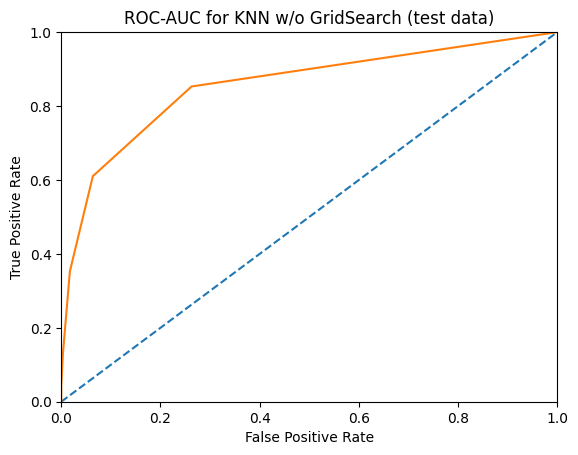

In [270]:
pred_test3 = model3.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test3)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < применим функции plt.xlim() и plt.ylim(), чтобы
#   установим границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < применим функции plt.xlabel() и plt.ylabel(), чтобы
#   подпишем оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавим к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-AUC for KNN w/o GridSearch (test data)')
plt.show();

Сравните между собой две лучшие модели:

1) насколько сильно отличается качество предсказания на тестовых данных?
(вычислите разность значений roc-auc на тестовых данных)

2) постройте гистограмму важности признаков для логистической регрессии. Какие три признака наиболее важны для модели?

In [272]:
# Print the ROC AUC scores for each model and their difference
print("ROC-AUC for Log Reg w/o GridSearch on test data: ", roc_auc)
print("ROC-AUC for KNN w/o GridSearch on test data: ", roc_auc_knn3)
print()
print("ROC AUC score difference: ", roc_auc - roc_auc_knn3)

ROC-AUC for Log Reg w/o GridSearch on test data:  0.5896309912854031
ROC-AUC for KNN w/o GridSearch on test data:  0.6677900326797386

ROC AUC score difference:  -0.0781590413943355


### Так можно построить гистограмму про важность признаков

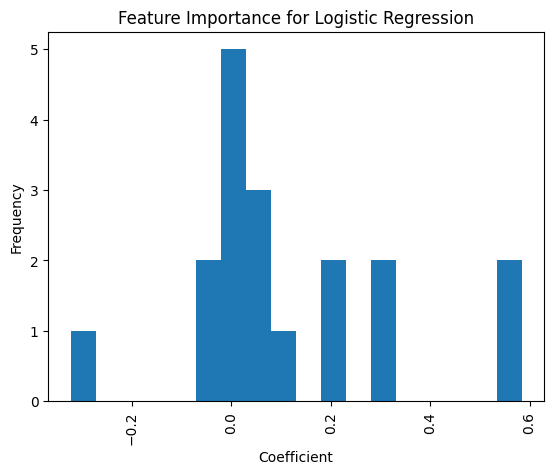

Top 3 most important features for logistic regression:
Customer service calls : 0.5839524020653911
International plan : 0.5520599475969162
Total day charge : 0.29000533100933795


In [274]:
# Get the feature importance coefficients for logistic regression
coef = best_lg.best_estimator_.coef_[0]

# Get the feature names
feature_names = X_train.columns

# Plot the feature importance as a histogram
plt.hist(coef, bins=len(feature_names))
plt.xticks(rotation=90)
plt.xlabel("Coefficient")
plt.ylabel("Frequency")
plt.title("Feature Importance for Logistic Regression")
plt.show()

# Print the top 3 most important features
top_features = sorted(zip(coef, feature_names), reverse=True)[:3]
print("Top 3 most important features for logistic regression:")
for coef, feature in top_features:
    print(feature, ":", coef)

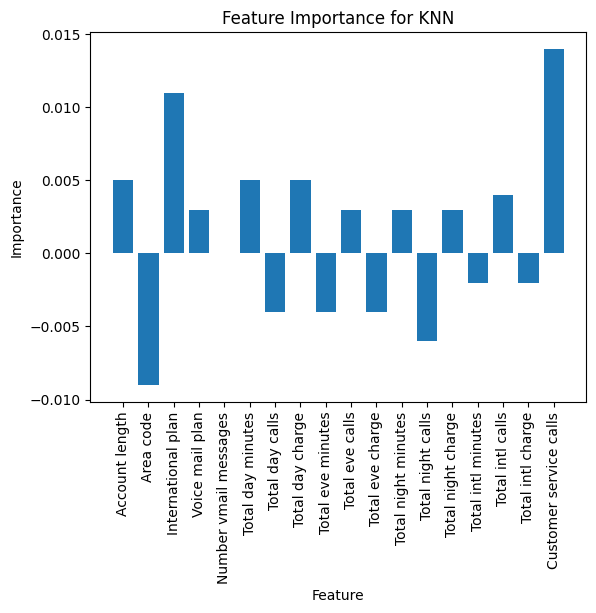

Top 3 most important features for KNN:
Customer service calls : 0.014000000000000012
International plan : 0.01100000000000001
Total day minutes : 0.0050000000000000044


In [279]:
# Get the baseline performance of the model
baseline_score = model3.score(X_test, y_test)

# Get the feature names
feature_names = X_train.columns.tolist()

# Compute the feature importance scores by removing one feature at a time and measuring the drop in performance
importances = []
for i in range(len(feature_names)):
    # Remove the i-th feature from the data
    X_train_reduced = X_train.drop([feature_names[i]], axis=1)
    X_test_reduced = X_test.drop([feature_names[i]], axis=1)

    # Fit the model to the reduced data and compute the performance drop
    model_reduced = KNeighborsClassifier(n_neighbors=3)
    model_reduced.fit(X_train_reduced, y_train)
    score_reduced = model_reduced.score(X_test_reduced, y_test)
    importance = baseline_score - score_reduced

    importances.append(importance)

# Plot the feature importance as a histogram
plt.bar(feature_names, importances)
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance for KNN")
plt.show()

# Print the top 3 most important features
top_features = sorted(zip(importances, feature_names), reverse=True)[:3]
print("Top 3 most important features for KNN:")
for importance, feature in top_features:
    print(feature, ":", importance)

In [220]:
# features = X_train.columns
# importances = np.abs(best_lg.coef_[0])
# indices = np.argsort(importances)
#
# plt.title('Feature Importances of LogisticRegression')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

Сделайте выводы:

1) Являются ли данные сбалансированными? Что это означает?

2) Какая модель после подбора гиперпараметров лучше всего решает задачу с точки зрения метрики roc-auc?

### Интерпретация модели

The KNN model in scikit-learn does not have coefficients or an intercept like the logistic regression model. Instead, the KNN algorithm assigns weights to the k-nearest neighbors of a given sample based on their distances, and the target label for the sample is determined by a majority vote among these neighbors.

If we want to examine the weights of the KNN model in scikit-learn, you can look at the distance metric and/or the number of neighbors used for classification. These hyperparameters can be adjusted in the KNeighborsClassifier() function. For example, you can print the number of neighbors used for classification with the following code:

In [292]:
model3.n_neighbors

5

We can also print the distance metric used by the KNN model with the following code:

In [293]:
model3.effective_metric_

'euclidean'

In [294]:
# Get the distances and indices of the k-nearest neighbors for each sample in the test set
distances, indices = model3.kneighbors(X_test)

# Create a DataFrame that contains the distances and indices of the k-nearest neighbors for each sample
knn_df = pd.DataFrame(distances, columns=[f"Distance {i+1}" for i in range(model3.n_neighbors)])
knn_df = pd.concat([knn_df, pd.DataFrame(indices, columns=[f"Index {i+1}" for i in range(model3.n_neighbors)])], axis=1)

# Calculate the majority vote for each sample
knn_df["Predicted Label"] = knn_df.iloc[:, -model3.n_neighbors:].mode(axis=1)[0]

# Print the DataFrame
print(knn_df.head())

   Distance 1  Distance 2  Distance 3  Distance 4  Distance 5  Index 1  \
0    2.607084    2.820620    2.927821    2.946168    2.984492     1128   
1    1.549685    1.698218    1.871226    1.941216    1.973087      654   
2    2.079316    2.228164    2.386796    2.436797    2.442540     1641   
3    2.204903    2.279131    2.332604    2.343625    2.358274     1694   
4    3.195811    3.472745    3.647690    3.769036    3.786255     2325   

   Index 2  Index 3  Index 4  Index 5  Predicted Label  
0      945      863     2291     2176              863  
1     1095     2162     1308      727              654  
2      533       46     1413     1387               46  
3     1074     1308      640     2279              640  
4       81     1760      974     1424               81  


#### The table contains information about the k-nearest neighbors for each sample and their distances to the sample. The predicted label for each sample is calculated based on the majority vote among these neighbors.

### Confusion Matrix

In [295]:
# Make predictions on the test data
y_pred = model3.predict(X_test)

# Build the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix for KNN:\n", cm)

Confusion matrix for KNN:
 [[849  15]
 [ 88  48]]


#### The confusion matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for the KNN model's predictions on the test data.

In this case, the confusion matrix has the following structure:

Predicted No Churn	Predicted   Churn
Actual No Churn	    TN = 849	FP = 15
Actual Churn	    FN = 88	    TP = 48

* True positives (TP): The number of correctly classified positive samples (Churn customers).
* True negatives (TN): The number of correctly classified negative samples (Non-Churn customers).
* False positives (FP): The number of non-Churn customers that were classified as Churn customers.
* False negatives (FN): The number of Churn customers that were classified as non-Churn customers.

In this case, we can see that the KNN model correctly classified 849 non-Churn customers as such, and 48 Churn customers as such. However, it misclassified 15 non-Churn customers as Churn customers (FP) and 88 Churn customers as non-Churn customers (FN).

#### In summary, the KNN model achieved an overall accuracy of (849 + 48) / (849 + 15 + 88 + 48) = 89.81%, but it had relatively high rates of false positives and false negatives.

In [301]:
# Save the model to a file
with open('C:\\Users\\HOME\\PycharmProjects\\nlp_upgrade\\Модуль 1. Введение в машинное обучение\\best_knn.h5', 'wb') as f:
    pickle.dump(model3, f)

In [302]:
# Load the saved model from a file
with open('C:\\Users\\HOME\\PycharmProjects\\nlp_upgrade\\Модуль 1. Введение в машинное обучение\\best_knn.h5', 'rb') as f:
    best_knn = pickle.load(f)